In [1]:
%timeit
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR


## Get Annotations and Images dirs

In [2]:
# define annoations and image directories
anno_paths = []
img_dirs = []
anno_base_path = '/kaggle/input/lisa-traffic-light-dataset/Annotations/Annotations'
img_base_path = '/kaggle/input/lisa-traffic-light-dataset'

# training and validation data
# get all the annotation and image directories
for train_type in ['dayTrain', 'nightTrain']: 
    anno_train_path = os.path.join(anno_base_path, train_type)
    img_train_path = os.path.join(img_base_path, train_type, train_type)

    for clip in os.listdir(anno_train_path):
        clip_path = os.path.join(anno_train_path, clip)
        
        if os.path.isdir(clip_path):
            # Annotation file path
            anno_file = os.path.join(clip_path, 'frameAnnotationsBULB.csv')
            if os.path.isfile(anno_file):
                anno_paths.append(anno_file)

    for clip in os.listdir(img_train_path):
        clip_path = os.path.join(img_train_path, clip)
        
        if os.path.isdir(clip_path):
            # Corresponding image directory path
            img_dir = os.path.join(clip_path, 'frames')
            if os.path.isdir(img_dir):
                img_dirs.append(img_dir)


# testing data
# get all the annotation and image directories
test_anno_paths = []
test_img_dirs = []
test_base_path = '/kaggle/input/lisa-traffic-light-dataset'
for test_type in ['dayClip6', 'nightClip1']:
    folder_name = 'sample-' + test_type
    anno_test_path = os.path.join(test_base_path, folder_name, folder_name, 'frameAnnotationsBULB.csv')
    img_test_path = os.path.join(test_base_path, folder_name, folder_name, 'frames')
    
    if os.path.isfile(anno_test_path):
        test_anno_paths.append(anno_test_path)
    
    if os.path.isdir(img_test_path):
        test_img_dirs.append(img_test_path)

        
print("test anno paths:", test_anno_paths, '\n')
print("test img dirs:", test_img_dirs)


test anno paths: ['/kaggle/input/lisa-traffic-light-dataset/sample-dayClip6/sample-dayClip6/frameAnnotationsBULB.csv', '/kaggle/input/lisa-traffic-light-dataset/sample-nightClip1/sample-nightClip1/frameAnnotationsBULB.csv'] 

test img dirs: ['/kaggle/input/lisa-traffic-light-dataset/sample-dayClip6/sample-dayClip6/frames', '/kaggle/input/lisa-traffic-light-dataset/sample-nightClip1/sample-nightClip1/frames']


## Dataset Model

In [3]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
from PIL import Image


class TrafficLightDataset(Dataset):
    def __init__(self, annotations_files, img_dirs, transform=None):
        # Concatenate all annotations into a single DataFrame
        self.annotations = pd.concat([pd.read_csv(f, sep=';') for f in annotations_files], ignore_index=True)
        self.img_dirs = img_dirs
        self.transform = transform
        self.class_to_idx = {'stop': 1, 
                             'stopLeft': 2, 
                             'go': 3, 
                             'goLeft': 4, 
                             'warningLeft': 5, 
                             'warning': 6} # 6 classes 

        # Group by image path for aggregating annotations
        self.images = self.annotations['Filename'].unique()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get the filename for the current index
        img_filename = self.images[idx]

        # Filter annotations for the current image
        img_annotations = self.annotations[self.annotations['Filename'] == img_filename]

        # Extract all bounding boxes and labels
        boxes = img_annotations[['Upper left corner X', 'Upper left corner Y', 'Lower right corner X', 'Lower right corner Y']].values.astype('float')
        labels = img_annotations['Annotation tag'].apply(lambda x: self.class_to_idx[x]).values

        # Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64).squeeze()  # Squeeze to make it 1D

        # Ensure that boxes and labels are at least 1D
        if boxes.ndim == 0:
            boxes = boxes.unsqueeze(0)
        if labels.ndim == 0:
            labels = labels.unsqueeze(0)

        # Find the corresponding image directory
        # Extract the clip directory name (e.g., 'dayClip6')
        relative_img_path = img_annotations.iloc[0, 0]
        clip_dir_name = relative_img_path.split('/')[1].split('--')[0]
        img_dir = None
        for dir in self.img_dirs:
            if dir.endswith(clip_dir_name + '/frames'):
                img_dir = dir
                break

        full_img_path = os.path.join(img_dir, img_filename.split('/')[1])

        # Load the image
        image = Image.open(full_img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # The target is now a dictionary
        target = {'boxes': boxes, 'labels': labels}
        
        return image, target

    
    def get_unique_labels(self):
        # extract unique labels from the annotations DataFrame
        return self.annotations['Annotation tag'].unique().tolist()
    


## Create Train and Val data

In [4]:
# resize images to 3x800x800 and convert to tensor
# 3 layers for RGB values normalized to 0-1
transform = transforms.Compose([transforms.Resize((960, 1280)), transforms.ToTensor()])

# create dataset
dataset = TrafficLightDataset(anno_paths, img_dirs, transform=transform)
test_dataset = TrafficLightDataset(test_anno_paths, test_img_dirs, transform=transform)

# examine unique labels in the dataset
unique_labels = dataset.get_unique_labels()
print("Unique Labels in the Dataset:", unique_labels)

# define size of train and validation data
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# split dataset into train and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# view size of each dataset
print(f"Training Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(val_dataset)} samples")
print(f"Testing Dataset: {len(test_dataset)} samples")

# print first 5 samples from each dataset
print('Data samples from train_dataset')
for i in range(5):  # first 5 samples in train_dataset
    image, box = train_dataset[i]
    print(f"Image {i}: Shape - {image.shape}, Box - {box}")

print('Data samples from val_dataset')
for i in range(5):  # first 5 samples in val_dataset
    image, box = val_dataset[i]
    print(f"Image {i}: Shape - {image.shape}, Box - {box}")
    
print('Data samples from test_dataset')
for i in range(5):  # first 5 samples in val_dataset
    image, box = test_dataset[i]
    print(f"Image {i}: Shape - {image.shape}, Box - {box}")


Unique Labels in the Dataset: ['go', 'warning', 'stop', 'goLeft', 'warningLeft', 'stopLeft']
Training Dataset: 14510 samples
Validation Dataset: 3628 samples
Testing Dataset: 910 samples
Data samples from train_dataset
Image 0: Shape - torch.Size([3, 960, 1280]), Box - {'boxes': tensor([[1065.,  386., 1069.,  390.]]), 'labels': tensor([1])}
Image 1: Shape - torch.Size([3, 960, 1280]), Box - {'boxes': tensor([[ 849.,  187.,  860.,  200.],
        [ 996.,  220., 1005.,  230.],
        [1167.,  300., 1176.,  309.]]), 'labels': tensor([1, 1, 1])}
Image 2: Shape - torch.Size([3, 960, 1280]), Box - {'boxes': tensor([[ 680.,  377.,  685.,  382.],
        [ 812.,  416.,  821.,  425.],
        [ 935.,  144.,  954.,  165.],
        [1148.,  196., 1164.,  214.],
        [ 737.,  137.,  757.,  156.]]), 'labels': tensor([3, 3, 1, 1, 2])}
Image 3: Shape - torch.Size([3, 960, 1280]), Box - {'boxes': tensor([[ 935.,  183.,  951.,  201.],
        [1143.,  230., 1163.,  253.],
        [ 737.,  137.,  75

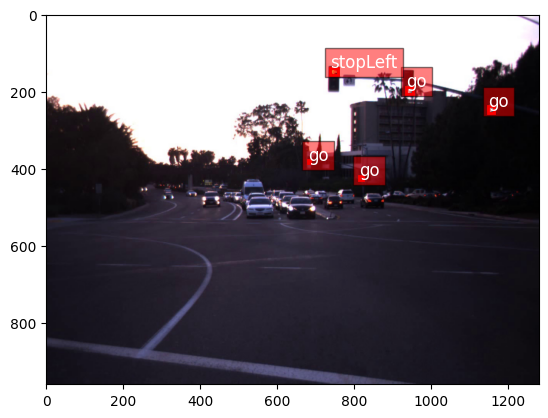

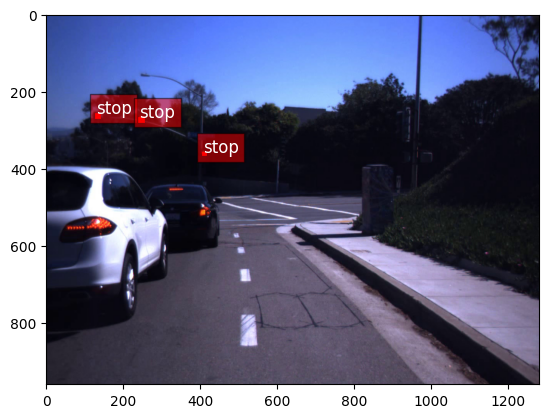

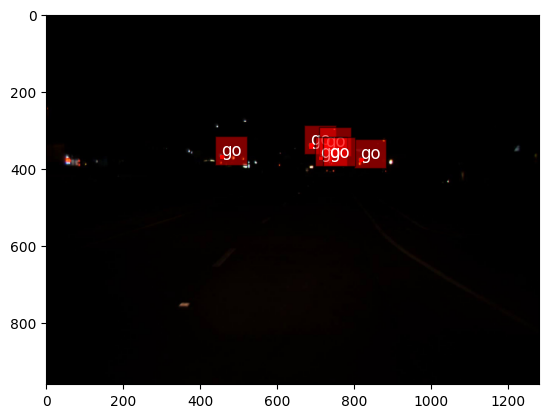

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class_to_idx = {'stop': 1, 
                 'stopLeft': 2, 
                 'go': 3, 
                 'goLeft': 4, 
                 'warningLeft': 5, 
                 'warning': 6} # 6 classes 

def show_sample_images(dataset, class_to_idx, num_samples=3):
    sample_indices = torch.randperm(len(dataset))[:num_samples]

    for idx in sample_indices:
        image, target = dataset[idx]

        # If the image is a PIL Image, convert it to numpy array
        if isinstance(image, Image.Image):
            np_image = np.array(image)
        else:
            # Assuming the image is a PyTorch tensor
            np_image = image.permute(1, 2, 0).numpy()

        fig, ax = plt.subplots(1)
        ax.imshow(np_image)

        for box, label in zip(target['boxes'], target['labels']):
            x, y, x2, y2 = box
            width, height = x2 - x, y2 - y
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Use the provided class_to_idx mapping
            label_name = [k for k, v in class_to_idx.items() if v == label.item()][0]
            plt.text(x, y, label_name, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

        plt.show()
        
# Example usage
show_sample_images(train_dataset, class_to_idx)


## Define Dataloaders

In [6]:
from torch.utils.data.dataloader import default_collate

def custom_collate_fn(batch):
    # Separate images and targets
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Use default_collate to correctly batch images
    batched_images = default_collate(images)

    return batched_images, targets

# define dataloaders with custom collate function
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=custom_collate_fn)


print(train_loader, val_loader)

<torch.utils.data.dataloader.DataLoader object at 0x7d67e49240a0> <torch.utils.data.dataloader.DataLoader object at 0x7d67e49269b0>


## Model Define

In [7]:
from collections import OrderedDict

# Load a pre-trained model for classification and return only the features
# define a custom wrapper for the backbone
class MobileNetV2Backbone(torch.nn.Module):
    def __init__(self, pretrained=True):
        super(MobileNetV2Backbone, self).__init__()
        # Load a pre-trained MobileNet V2 model
        mobilenet_v2 = torchvision.models.mobilenet_v2(pretrained=pretrained).features
        self.backbone = mobilenet_v2

    def forward(self, x):
        # Forward pass through the backbone
        x = self.backbone(x)
        # Create an OrderedDict with a single feature map
        return OrderedDict([('0', x)])


# backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone = MobileNetV2Backbone(pretrained=True)
backbone.out_channels = 1280

# Faster R-CNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
anchor_generator = AnchorGenerator(sizes=((32, 48, 64, 80, 96),),
                                   aspect_ratios=((0.75, 1.0, 1.25),))

# Let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# If your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# Put the pieces together inside a FasterRCNN model
num_classes = 7  # 'stop', 'stopLeft', 'go', 'goLeft', 'warningLeft', 'warning', and 'background'
model = FasterRCNN(backbone,
                   num_classes=num_classes,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 25.4MB/s]


## Training Loop

In [8]:
import shutil
# shutil.rmtree('/kaggle/working/runs')
# os.remove("/kaggle/working/FasterRCNN_epoch_5.pth")
# os.remove("/kaggle/working/FasterRCNN_final.pth")

print('done')

done


#### Function: Calculate Intersection over Union (IoU)
- Compare intersection between area of prediciton box and ground truth box

In [9]:
def calculate_iou(pred_box, gt_box):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters:
    pred_box (list of floats): [xmin, ymin, xmax, ymax] for predicted box.
    gt_box (list of floats): [xmin, ymin, xmax, ymax] for ground truth box.

    Returns:
    float: IoU value.
    """
    # Coordinates of the intersection box
    x_left = max(pred_box[0], gt_box[0])
    y_top = max(pred_box[1], gt_box[1])
    x_right = min(pred_box[2], gt_box[2])
    y_bottom = min(pred_box[3], gt_box[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Area of intersection
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Area of both the prediction and ground truth rectangles
    pred_box_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_box_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])

    # Compute the union area by using formula: union(A,B) = A + B - intersection(A,B)
    union_area = pred_box_area + gt_box_area - intersection_area

    # Compute the IoU
    iou = intersection_area / union_area

    return iou

#### Function: Evalutate Predictions
- Iterate through every comparison of prediction box and ground truth box
- Find the best match for each prediction
- Calculate TP, FP, FN

In [10]:
def evaluate_predictions(output, target, iou_threshold=0.2):
    # Initialize metrics
    TP, FP, FN = 0, 0, 0

    # Extract predicted and ground truth boxes and labels
    pred_boxes = output.get('boxes', [])
    pred_labels = output.get('labels', [])
    gt_boxes = target.get('boxes', [])
    gt_labels = target.get('labels', [])

    matched_gt = set()  # To track which ground-truth boxes have been matched

    for i, pred_box in enumerate(pred_boxes):
        # Check if prediction matches any ground truth
        matched = False
        for j, gt_box in enumerate(gt_boxes):
            iou = calculate_iou(pred_box, gt_box)
            if iou >= iou_threshold and pred_labels[i] == gt_labels[j] and j not in matched_gt:
                matched = True
                matched_gt.add(j)
                break

        if matched:
            TP += 1
        else:
            FP += 1

    # All unmatched ground truth boxes are False Negatives
    FN = len(gt_boxes) - len(matched_gt)

    # Calculate precision and recall
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0

    return {'TP': TP, 'FP': FP, 'FN': FN, 'precision': precision, 'recall': recall}

#### Training Loop - First 10 epochs

In [ ]:
import os
import time
from torch.utils.tensorboard import SummaryWriter

# Move model to the appropriate device (GPU if available)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Initialize the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Set up TensorBoard writer if you want to use TensorBoard for monitoring
writer = SummaryWriter()

# Training loop ===========================================================
num_epochs = 20  # define the number of epochs
training_losses = [] # record loss for each epoch
precisions = [] # record precision for each epoch
recalls = [] # record recall for each epoch
accuracies = [] # record accuracy for each epoch
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    start_time = time.time()
    
    # Training phase ======================================================
    for batch_idx, (images, targets) in enumerate(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        total_train_loss += losses.item()

        # print status to ensure the kernel doesn't disconnect due to inactivity
        if batch_idx % 500 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {losses.item()}")

            # Optional: log to TensorBoard
            writer.add_scalar('training_loss', losses.item(), epoch * len(train_loader) + batch_idx)
    

    # Calculate the average loss and log it to TensorBoard
    avg_train_loss = total_train_loss / len(train_loader)
    writer.add_scalar('avg_training_loss', avg_train_loss, epoch)
    training_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss}")

    # Save the model after each epoch
    checkpoint_path = f"/kaggle/working/FasterRCNN_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")
    
    # Update the learning rate at the end of each epoch
    scheduler.step()
    
    # Validation phase ======================================================
    model.eval()
    total_val_loss = 0
    metrics = {'TP': 0, 'FP': 0, 'FN': 0}
    for batch_idx, (images, targets) in enumerate(val_loader):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            outputs = model(images)
            for output, target in zip(outputs, targets):
                # Evaluate predictions
                eval_result = evaluate_predictions(output, target)
                for k in metrics:
                    metrics[k] += eval_result[k]
                    
        if batch_idx % 100 == 0:
            print(f"Epoch: {epoch+1}, Batch: {batch_idx}, Metrics: {metrics}")
                    
    # Calculate accuracy, precision, recall
    precision = metrics['TP'] / (metrics['TP'] + metrics['FP']) if metrics['TP'] + metrics['FP'] > 0 else 0
    recall = metrics['TP'] / (metrics['TP'] + metrics['FN']) if metrics['TP'] + metrics['FN'] > 0 else 0
    accuracy = metrics['TP'] / sum(metrics.values())
    
    # record metrics
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    
    # Log validation metrics
    print(f"Epoch [{epoch+1}/{num_epochs}],Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}")

    # Print epoch duration
    end_time = time.time()
    print(f"Epoch {epoch+1} completed in {end_time - start_time} seconds")
    print("\n")

    
# Save the final trained model ======================================================
final_model_path = "/kaggle/working/FasterRCNN_final.pth"
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Epoch 1, Batch 0, Loss: 2.705462694168091
Epoch 1, Batch 500, Loss: 0.06127066910266876
Epoch 1, Batch 1000, Loss: 0.027249250560998917
Epoch 1, Batch 1500, Loss: 0.043937936425209045
Epoch 1, Batch 2000, Loss: 0.07851859927177429
Epoch 1, Batch 2500, Loss: 0.03979967162013054
Epoch 1, Batch 3000, Loss: 0.04298146069049835
Epoch 1, Batch 3500, Loss: 0.042423270642757416
Epoch [1/20], Training Loss: 0.09892938705879985
Checkpoint saved to /kaggle/working/FasterRCNN_epoch_1.pth
Epoch: 1, Batch: 0, Metrics: {'TP': 11, 'FP': 58, 'FN': 1}
Epoch: 1, Batch: 100, Metrics: {'TP': 1033, 'FP': 6605, 'FN': 126}
Epoch: 1, Batch: 200, Metrics: {'TP': 2056, 'FP': 13602, 'FN': 246}
Epoch: 1, Batch: 300, Metrics: {'TP': 3029, 'FP': 20598, 'FN': 407}
Epoch: 1, Batch: 400, Metrics: {'TP': 4044, 'FP': 27705, 'FN': 548}
Epoch: 1, Batch: 500, Metrics: {'TP': 5050, 'FP': 34663, 'FN': 692}
Epoch: 1, Batch: 600, Metrics: {'TP': 6066, 'FP': 41362, 'FN': 830}
Epoch: 1, Batch: 700, Metrics: {'TP': 7090, 'FP': 485

#### Training Losses Over Epochs

In [ ]:
import matplotlib.pyplot as plt

epochs = range(0, num_epochs)

# Create a line plot of losses over epochs
plt.plot(epochs, training_losses, marker='o', linestyle='-', color='blue')

# Optionally, add a title and labels to the axes
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# add a grid for better readability
plt.grid(True)

# show
plt.show()

## Testing

In [ ]:
# Load the trained model
model.load_state_dict(torch.load("/kaggle/input/fasterrcnn/FasterRCNN_final.pth"))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)
model.eval()  # Set the model to evaluation mode


# Initialize a list to store the predictions
predictions = []
precisions = [] # record precision for each epoch
recalls = [] # record recall for each epoch
accuracies = [] # record accuracy for each epoch

metrics = {'TP': 0, 'FP': 0, 'FN': 0}

# Testing phase ======================================================
for batch_idx, (images, targets) in enumerate(test_loader):
    # Move images to the appropriate device
    images = [image.to(device) for image in images]
    
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        outputs = model(images)
        predictions.extend(outputs)
        for output, target in zip(outputs, targets):
            # Evaluate predictions
            eval_result = evaluate_predictions(output, target)
            for k in metrics:
                metrics[k] += eval_result[k]
        
    
    if batch_idx % 50 == 0:
        print(f"Batch {batch_idx}, Metrics: {metrics}")
        
# Calculate accuracy, precision, recall
precision = metrics['TP'] / (metrics['TP'] + metrics['FP']) if metrics['TP'] + metrics['FP'] > 0 else 0
recall = metrics['TP'] / (metrics['TP'] + metrics['FN']) if metrics['TP'] + metrics['FN'] > 0 else 0
accuracy = metrics['TP'] / sum(metrics.values())

# record metrics
precisions.append(precision)
recalls.append(recall)
accuracies.append(accuracy)

# Log validation metrics
print(f"Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}")


# Process the predictions as required
# For example, to print out the predictions for the first 5 images:
for i, output in enumerate(predictions[:5]):
    print(f"Image {i}: {output}")

    